In [1]:
!pip3 install pyro-ppl

In [2]:
import pyro
import pyro.distributions as dist

import random

import numpy as np

import torch

# 1. Generate Sample Dataset

In [3]:
class GMMSampler:

    def __init__(self, k, d, mu, sigma):
        self.k = k
        self.d = d

        assert mu.size() == (k, d), 'Input mu must be a tensor of size (%i, %i)' % (k, d)
        self.mu = mu

        assert sigma.size() == (k, d), 'Input sigma must be a tensor of size (%i, %i)' % (k, d)
        self.sigma = sigma

        self.init_gaussians()

    def init_gaussians(self):
        self.gaussians = [[dist.Normal(self.mu[k, d], self.sigma[k, d]) for d in range(self.d)] for k in range(self.k)]

    def sample(self, n):
        choices = np.random.choice(self.k, n, replace=True)
        samples = torch.zeros(n, self.d)

        for i, c in enumerate(choices):
            for d in range(self.d):
                component = self.gaussians[c][d] 
                samples[i, d] = component.sample()

        return samples

In [4]:
K = 2 

D = 2 

MU = torch.tensor([[-.5, -.5], [.5, .5]], dtype=torch.float)

SIGMA = torch.tensor([[.1, .1], [.1, .1]], dtype=torch.float)

In [5]:
bimodal_sampler = GMMSampler(K, D, MU, SIGMA)

In [6]:
N = 10000

assert N > K, 'Dataset size N must be greater'

data = bimodal_sampler.sample(N)

data

tensor([[ 0.4707,  0.5099],
        [ 0.6309,  0.7051],
        [ 0.5323,  0.4226],
        ...,
        [ 0.5659,  0.4611],
        [-0.6543, -0.5686],
        [-0.3426, -0.5749]])

In [7]:
import matplotlib.pyplot as plt

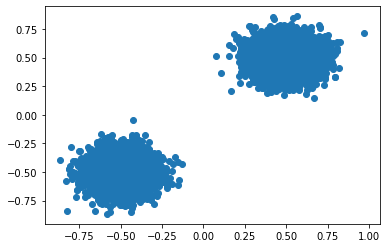

In [8]:
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [9]:
def split_train_test(data, ratio=0.8):

    N = data.shape[0]
    indices = torch.randperm(N)

    N_train = int(N * ratio)

    train_indices = indices[:N_train]
    test_indices = indices[N_train:]

    data_train = data[train_indices]
    data_test = data[test_indices]

    return data_train, data_test

In [10]:
data_train, data_test = split_train_test(data)

# 2. Define the Pyro Model

In [11]:
from pyro.infer import config_enumerate

from torch.distributions import constraints

In [12]:
K = 2 # number of components

def model(data):

    N = data.shape[0] # number of samples
    D = 1 if len(data.shape) == 1 else data.shape[1] # data dimensionality

    # Global variables as initialized in the paper with Stan 

    # Component weights
    theta = pyro.sample('theta', dist.Dirichlet(torch.ones(K) / K))

    # Locs and scales of the components
    with pyro.plate('dimensions', D):
        with pyro.plate('components', K):
            mu = pyro.sample('mu', dist.Normal(torch.tensor([0.]), torch.tensor([1.])))
            sigma = pyro.sample('sigma', dist.LogNormal(torch.tensor([0.]), torch.tensor([1])))

    with pyro.plate('data', N):
        assignment = pyro.sample('assignment', dist.Categorical(theta), infer={'enumerate': 'parallel'})
        pyro.sample('obs', dist.Normal(mu[assignment], sigma[assignment]).to_event(1), obs=data)

# 3. Run ADVI

In [13]:
import torch.nn as nn

import pandas as pd

from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal

import time

from tqdm.notebook import tqdm, trange

In [14]:
from pyro.infer.autoguide.initialization import init_to_sample, init_to_uniform, init_to_value

init_values = {
    'mu': torch.mean(data_train, dim=0).expand(K, D), 
    'sigma': torch.std(data_train, dim=0).expand(K, D), 
    'theta': torch.ones(K) / K
    }

def run_advi(model, num_iter, num_particles, verbose=False):
    torch.manual_seed(0)

    guide = AutoDiagonalNormal(poutine.block(model, expose=['theta', 'mu', 'sigma']), init_loc_fn=init_to_value(values=init_values, fallback=init_to_sample))
    #guide = AutoDiagonalNormal(poutine.block(model, expose=['theta', 'mu', 'sigma']))
    adaprop = pyro.optim.AdagradRMSProp(dict())

    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = pyro.optim.Adam(adam_params)
    svi = SVI(model, guide, optimizer, loss=TraceEnum_ELBO(num_particles=num_particles)) # TraceEnum_ELBO is crucial

    pyro.clear_param_store()

    output_advi = pd.DataFrame(columns = ['t', 'test_accuracy', 'model'])

    train_time = 0

    mse_loss = nn.MSELoss()

    for j in trange(num_iter):
        t0 = time.time()
        loss = svi.step(data_train)
        train_time += time.time() - t0
    
        if j % 100 == 0:
            learned_theta = guide.median()['theta']
            learned_mu = guide.median()['mu']
            learned_sigma = guide.median()['sigma']
            
            # Compute Likelihood as in the paper
            test_log_prob = 0
            for n in range(data_test.shape[0]):
                ps = torch.zeros(K, 1)
                for k in range(K):
                    learned_normal = dist.Normal(learned_mu[k], learned_sigma[k])
                    ps[k] = torch.log(learned_theta[k]) + learned_normal.log_prob(data_test[n]).sum()
                test_log_prob += torch.logsumexp(ps.flatten(), dim=-1)

            output_iter = {'t': train_time,
                           'test_accuracy': test_log_prob.detach().numpy(),
                           'model': 'advi{}'.format(num_particles)}
            output_advi = output_advi.append(output_iter, ignore_index=True)
            
            if verbose: 
                print('[iteration %04d] test_accuracy: %.4f' % (j + 1, test_log_prob))  

    return output_advi

In [15]:
# Train the ADVI models
print('Running ADVI with M=1')
output_advi_M1 = run_advi(model, 1000, 1, True)

print('Running ADVI with M=10')
output_advi_M10 = run_advi(model, 1000, 10, True)

Running ADVI with M=1


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2965.4407
[iteration 0101] test_accuracy: -2437.6240
[iteration 0201] test_accuracy: 528.9643
[iteration 0301] test_accuracy: 1873.8390
[iteration 0401] test_accuracy: 2166.8274
[iteration 0501] test_accuracy: 2151.5024
[iteration 0601] test_accuracy: 2157.6755
[iteration 0701] test_accuracy: 2187.1609
[iteration 0801] test_accuracy: 2183.4631
[iteration 0901] test_accuracy: 2197.0198
Running ADVI with M=10


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2964.8127
[iteration 0101] test_accuracy: -1402.9865
[iteration 0201] test_accuracy: 1079.5089
[iteration 0301] test_accuracy: 2065.0010
[iteration 0401] test_accuracy: 2187.2087
[iteration 0501] test_accuracy: 2192.7744
[iteration 0601] test_accuracy: 2195.1628
[iteration 0701] test_accuracy: 2197.3811
[iteration 0801] test_accuracy: 2196.7271
[iteration 0901] test_accuracy: 2195.9868


In [16]:
output_advi_M1

,t,test_accuracy,model
0,0.087026,-2965.4407,advi1
1,2.460452,-2437.624,advi1
2,6.409368,528.9643,advi1
3,10.912412,1873.839,advi1
4,15.801922,2166.8274,advi1
5,20.548471,2151.5024,advi1
6,24.468748,2157.6755,advi1
7,26.920039,2187.161,advi1
8,29.434793,2183.4631,advi1
9,31.862766,2197.0198,advi1


In [17]:
output_advi_M10

,t,test_accuracy,model
0,0.231754,-2964.8127,advi10
1,19.789020,-1402.9865,advi10
2,39.612446,1079.5089,advi10
3,59.505884,2065.001,advi10
4,82.574978,2187.2087,advi10
5,105.801488,2192.7744,advi10
6,130.257675,2195.1628,advi10
7,153.579008,2197.381,advi10
8,177.048836,2196.727,advi10
9,200.769271,2195.9868,advi10


# 4. Run NUTS


In [18]:
from pyro.infer import MCMC, NUTS, HMC

In [19]:
def run_mcmc(model, num_samples, num_warmups, kernel_method):
    torch.manual_seed(0)
    
    pyro.clear_param_store()

    test_log_prob_arr = []
    train_time = []

    def hook_fn(kernel, sample, stage, i):
        # Use the most recently sampled param to estimate performance
        if i < 100 or (i % 10 == 0): # Evaluate all first 100 samples and then every 50
            learned_theta = sample['theta'] # RETURNS A ONE-DIMENSIONAL SAMPLE I COULD NOT UNDERSTAND 
            learned_mu = sample['mu']
            learned_sigma = torch.exp(sample['sigma'])

            #print('11111', learned_mu)
            #print('22222', learned_sigma)

            # Compute Likelihood as in the paper
            test_log_prob = 0
            for n in range(data_test.shape[0]):
                ps = torch.zeros(K, 1)
                for k in range(K):
                    learned_normal = dist.Normal(learned_mu[k], learned_sigma[k])
                    if k == K - 1:
                        ps[k] = torch.log(1 - torch.sum(learned_theta)) + learned_normal.log_prob(data_test[n]).sum()
                    else:  
                        ps[k] = torch.log(learned_theta[k]) + learned_normal.log_prob(data_test[n]).sum()
                test_log_prob += torch.logsumexp(ps.flatten(), dim=-1)

            train_time.append(time.time())    
            test_log_prob_arr.append(test_log_prob)

    if kernel_method == 'NUTS':
        kernel = NUTS(model,max_tree_depth=4)
    elif kernel_method == 'HMC':
        kernel = HMC(model,
                     step_size=0.1, 
                     num_steps=10, 
                     target_accept_prob=0.8,
                     adapt_step_size = False)
    else:
        raise Exception('Unknown Kernel Method.')

    nuts = MCMC(kernel,
                num_samples=num_samples,
                warmup_steps=num_warmups,
                disable_progbar=False,
                num_chains=1,
                hook_fn=hook_fn) 

    nuts.run(data_train)

    output_mcmc = pd.DataFrame({'t': np.array(train_time) - train_time[0], 
                                'test_accuracy': np.array(test_log_prob_arr),
                                'model': kernel_method})
    
    return output_mcmc

In [20]:
# Train the MCMC models 
print('Running MCMC with NUTS kernel')
output_nuts = run_mcmc(model, 100, 100, 'NUTS')

# Does not produce any meaningful result
#print('Running MCMC with HMC kernel')
#output_hmc = run_mcmc(model, 2000, 2000, 'HMC')

Running MCMC with NUTS kernel


Sample: 100%|██████████| 200/200 [03:01,  1.10it/s, step size=1.68e-02, acc. prob=0.875]


In [21]:
import seaborn as sns

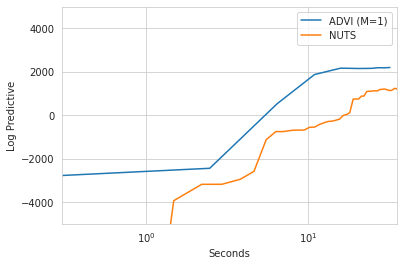

In [62]:
# Generate plot
output = output_advi_M1 #.append(output_advi_M10, ignore_index=True)
output = output.append(output_nuts, ignore_index=True)
#output = output.append(output_hmc, ignore_index=True)
output['test_accuracy'] = output['test_accuracy'].astype('float')

sns.set_style('whitegrid')
results = sns.lineplot(data=output, x='t', y='test_accuracy', hue='model')
results.set(xscale='log', 
            xlim=(0.3, 35), 
            ylim=(-5000, 5000),
            xlabel='Seconds',
            ylabel='Log Predictive')
plt.legend(labels=['ADVI (M=1)', 'NUTS']) #, 'HMC'])

In [23]:
# Train the ADVI models for larger M, gives no sifnificant improvement
#print('Running ADVI with M=50')
#output_advi_M50 = run_advi(model, 1000, 50, True)

#print('Running ADVI with M=500')
#output_advi_M500 = run_advi(model, 1000, 500, True)

In [24]:
three_modal_sampler = GMMSampler(3, 
                                 2, 
                                 torch.tensor([[-.5, -.5], [.5, .5], [0, 0]], dtype=torch.float), 
                                 torch.tensor([[.1, .1], [.1, .1], [.1, .1]], dtype=torch.float))

data3 = three_modal_sampler.sample(N)

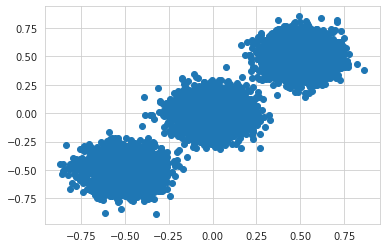

In [25]:
plt.scatter(data3[:, 0], data3[:, 1])
plt.show()

In [26]:
data_train, data_test = split_train_test(data3)

# Train the ADVI model
print('Running ADVI with M=1 and K=3')
output_advi_M1_K3 = run_advi(model, 1000, 1, True)

print('Running MCMC with NUTS kernel, K=3')
output_nuts_K3 = run_mcmc(model, 100, 100, 'NUTS')

Running ADVI with M=1 and K=3


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2329.8120
[iteration 0101] test_accuracy: -1942.5515
[iteration 0201] test_accuracy: -1000.8384
[iteration 0301] test_accuracy: -867.1387
[iteration 0401] test_accuracy: -401.1919
[iteration 0501] test_accuracy: -371.8603
[iteration 0601] test_accuracy: -359.0528
[iteration 0701] test_accuracy: -357.3049
[iteration 0801] test_accuracy: -356.6581
[iteration 0901] test_accuracy: -357.3215
Running MCMC with NUTS kernel, K=3


Sample: 100%|██████████| 200/200 [03:03,  1.09it/s, step size=7.60e-03, acc. prob=0.919]


In [27]:
five_modal_sampler = GMMSampler(5, 
                                2, 
                                torch.tensor([[-.5, -.5], [.5, .5], [-.5, .5], [.5, -.5], [0, 0]], dtype=torch.float), 
                                torch.tensor([[.1, .1], [.1, .1], [.1, .1], [.1, .1], [.1, .1]], dtype=torch.float))

data5 = five_modal_sampler.sample(N)

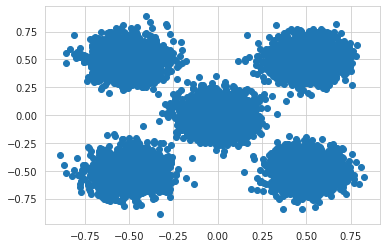

In [28]:
plt.scatter(data5[:, 0], data5[:, 1])
plt.show()

In [29]:
data_train, data_test = split_train_test(data5)

# Train the ADVI model
print('Running ADVI with M=1 and K=5')
output_advi_M1_K5 = run_advi(model, 1000, 1, True)

print('Running MCMC with NUTS kernel, K=5')
output_nuts_K5 = run_mcmc(model, 100, 100, 'NUTS')

Running ADVI with M=1 and K=5


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -2612.8374
[iteration 0101] test_accuracy: -2578.6128
[iteration 0201] test_accuracy: -2579.2793
[iteration 0301] test_accuracy: -2578.6628
[iteration 0401] test_accuracy: -2578.4597
[iteration 0501] test_accuracy: -2579.3064
[iteration 0601] test_accuracy: -2579.6353
[iteration 0701] test_accuracy: -2578.7932
[iteration 0801] test_accuracy: -2578.7700
[iteration 0901] test_accuracy: -2578.6736
Running MCMC with NUTS kernel, K=5


Sample: 100%|██████████| 200/200 [03:05,  1.08it/s, step size=3.81e-02, acc. prob=0.896]


In [30]:
ten_modal_sampler = GMMSampler(10, 
                               2, 
                               torch.tensor([[-.5, -.5], [.5, .5], [-.5, .5], [.5, -.5], [0, 0],
                                             [-.9, -.9], [.9, .9], [-.9, .9], [.9, -.9], [0, .8]], dtype=torch.float), 
                               torch.tensor([[.1, .1], [.1, .1], [.1, .1], [.1, .1], [.1, .1],
                                             [.1, .1], [.1, .1], [.1, .1], [.1, .1], [.1, .1]], dtype=torch.float))

data10 = ten_modal_sampler.sample(N)

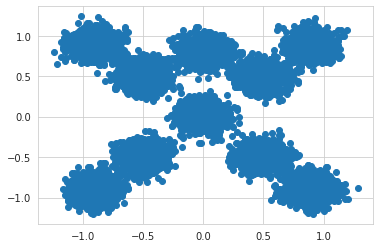

In [31]:
plt.scatter(data10[:, 0], data10[:, 1])
plt.show()

In [32]:
data_train, data_test = split_train_test(data10)

# Train the ADVI model
print('Running ADVI with M=1 and K=10')
output_advi_M1_K10 = run_advi(model, 1000, 1, True)

print('Running MCMC with NUTS kernel, K=10')
output_nuts_K10 = run_mcmc(model, 100, 100, 'NUTS')

Running ADVI with M=1 and K=10


  0%|          | 0/1000 [00:00<?, ?it/s]

[iteration 0001] test_accuracy: -4466.2017
[iteration 0101] test_accuracy: -4087.9932
[iteration 0201] test_accuracy: -4088.8481
[iteration 0301] test_accuracy: -4087.6919
[iteration 0401] test_accuracy: -4088.0232
[iteration 0501] test_accuracy: -4088.8286
[iteration 0601] test_accuracy: -4086.2322
[iteration 0701] test_accuracy: -4086.5681
[iteration 0801] test_accuracy: -4087.2952
[iteration 0901] test_accuracy: -4086.9592
Running MCMC with NUTS kernel, K=10


Sample: 100%|██████████| 200/200 [02:52,  1.16it/s, step size=4.54e-01, acc. prob=0.896]


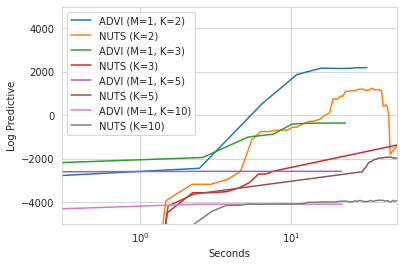

In [39]:
# Generate plot
output_advi_M1['test_accuracy'] = output_advi_M1['test_accuracy'].astype('float')
output_advi_M1_K3['test_accuracy'] = output_advi_M1_K3['test_accuracy'].astype('float')
output_advi_M1_K5['test_accuracy'] = output_advi_M1_K5['test_accuracy'].astype('float')
output_advi_M1_K10['test_accuracy'] = output_advi_M1_K10['test_accuracy'].astype('float')

sns.set_style('whitegrid')

results = sns.lineplot(data=output_advi_M1, x='t', y='test_accuracy')
results = sns.lineplot(data=output_nuts, x='t', y='test_accuracy')

results = sns.lineplot(data=output_advi_M1_K3, x='t', y='test_accuracy')
results = sns.lineplot(data=output_nuts_K3, x='t', y='test_accuracy')

results = sns.lineplot(data=output_advi_M1_K5, x='t', y='test_accuracy')
results = sns.lineplot(data=output_nuts_K5, x='t', y='test_accuracy')

results = sns.lineplot(data=output_advi_M1_K10, x='t', y='test_accuracy')
results = sns.lineplot(data=output_nuts_K10, x='t', y='test_accuracy')

results.set(xscale='log', 
            xlim=(0.3, 50), 
            ylim=(-5000, 5000),
            xlabel='Seconds',
            ylabel='Log Predictive')
plt.legend(labels=['ADVI (M=1, K=2)', 'NUTS (K=2)',
                   'ADVI (M=1, K=3)', 'NUTS (K=3)',
                   'ADVI (M=1, K=5)', 'NUTS (K=5)',
                   'ADVI (M=1, K=10)', 'NUTS (K=10)'])